# **Chapter 14**

## Recipes

- Understanding state-space models
- Decomposing time series with multiple seasonal patterns using MSTL
- Forecasting with multiple seasonal patterns using the Unobserved Components Model (UCM)
- Forecasting time series with multiple seasonal patterns using AutoTBATS
- Forecasting time series with multiple seasonal patterns using NeuralProphet


# Technical Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('grayscale')

In [2]:
pd.__version__

'2.3.3'

In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 4]   ##
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [4]:
import statsmodels as sm
from statsmodels.tools.eval_measures import rmse, meanabs as mae
print(f'''
statsmodels -> {sm.__version__}
''')



statsmodels -> 0.14.5



In [5]:
folder = Path('../../datasets/Ch14/')
file = folder.joinpath('AEP_hourly.csv')

df = pd.read_csv(file, index_col='Datetime', parse_dates=True)
df.shape

(121273, 1)

In [6]:
df.sort_index(inplace=True)
df = df.resample('H').last()
df.columns = ['y']
df.ffill(inplace=True)

print(f"Final dataset shape: {df.shape}")
print(f"Data frequency: {df.index.freq}")
print(f"Any missing values: {df.isnull().any().any()}")

Final dataset shape: (121296, 1)
Data frequency: <Hour>
Any missing values: False


In [7]:
df.head(10)

,y
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
2004-10-01 06:00:00,12280.0
2004-10-01 07:00:00,13692.0
2004-10-01 08:00:00,14618.0
2004-10-01 09:00:00,14903.0


<Axes: title={'center': 'American Power Electric Energy Consumption in Megawatts (MW)'}, xlabel='Datetime'>

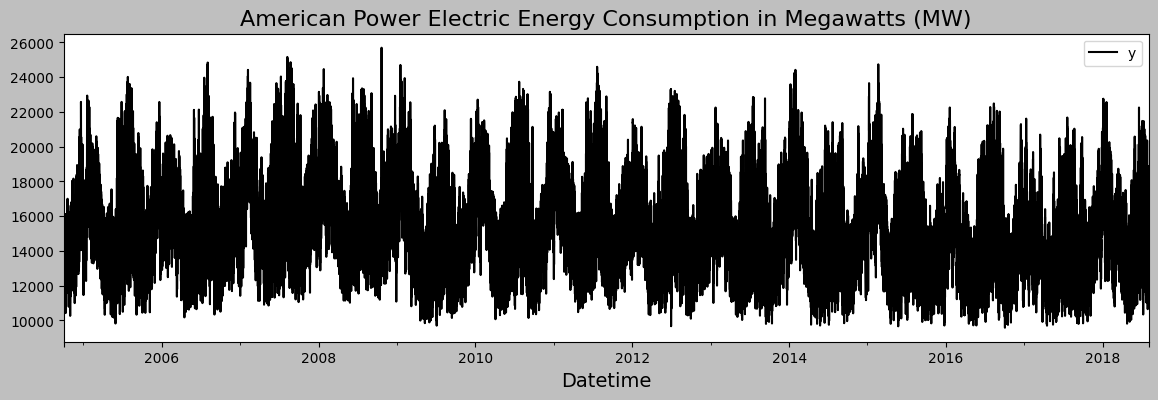

In [8]:
df.plot(title='American Power Electric Energy Consumption in Megawatts (MW)')

In [13]:
df.isna().sum()

y    0
dtype: int64

In [14]:
df.shape

(121296, 1)

In [15]:
set(df.index.year)

{2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018}

# Decomposing Time Series with Multiple Seasonality using MSTL

In [ ]:
from statsmodels.tsa.seasonal import MSTL
plt.rcParams["figure.figsize"] = [14, 8]

In [ ]:
day = 24
week = day*7
year = day*365
print(f'''
day = {day} hours
week = {week} hours
year = {year} hours
''')


day = 24 hours
week = 168 hours
year = 8760 hours



In [14]:
df.index.freq

<Hour>

In [15]:
df.values

array([[12379.],
       [11935.],
       [11692.],
       ...,
       [17001.],
       [15964.],
       [14809.]])

In [16]:
jump = 6
mstl = MSTL(df, 
            periods=(day, week, year),
            iterate=2,
            stl_kwargs={
                "seasonal_jump": jump,
                "trend_jump": jump,
                "low_pass_jump": jump
                }
            )
results = mstl.fit()

In [17]:
results

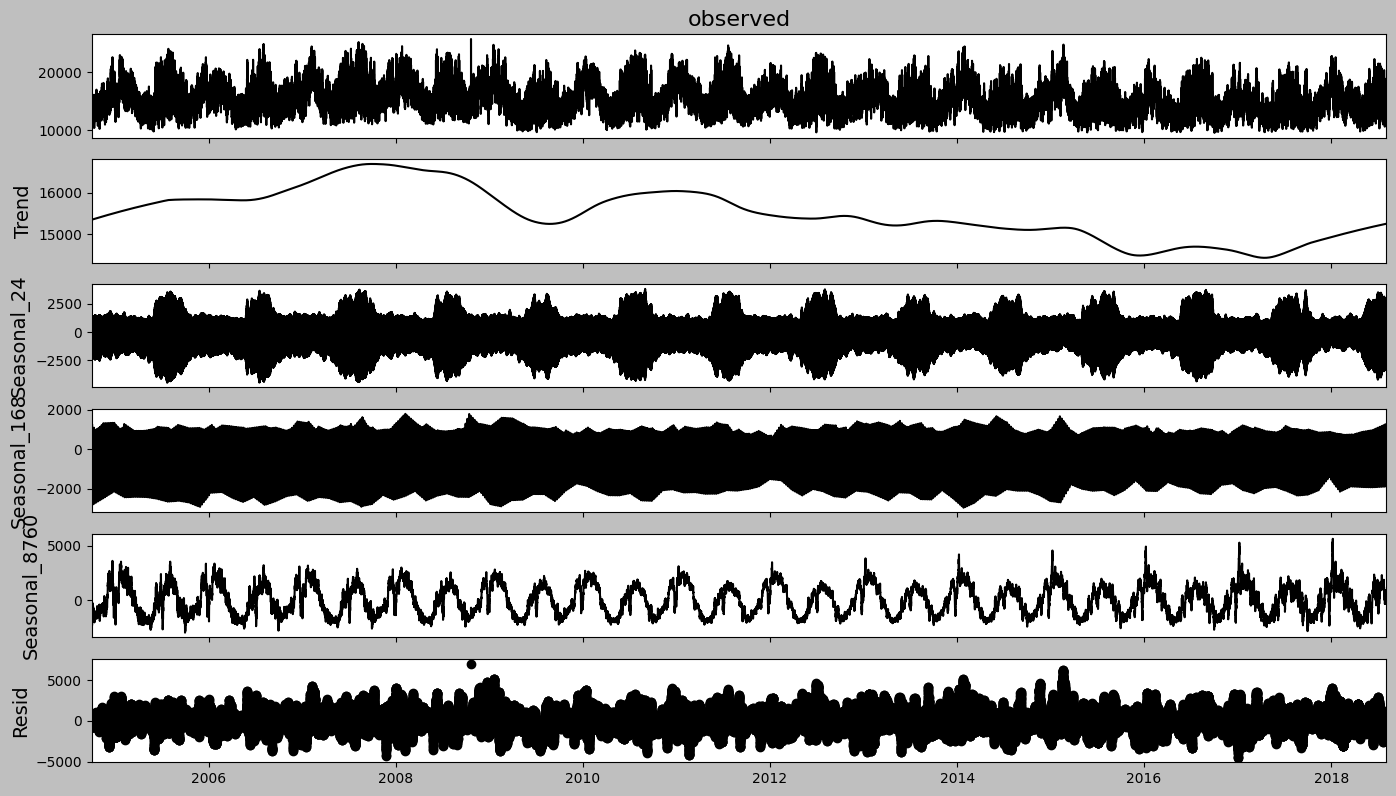

In [18]:
results.plot()
plt.show()

In [19]:
results.seasonal

,seasonal_24,seasonal_168,seasonal_8760
Datetime,,,
2004-10-01 01:00:00,-1601.607308,439.109914,-1983.307676
2004-10-01 02:00:00,-2070.264930,384.971488,-1871.446406
2004-10-01 03:00:00,-2287.059525,340.078464,-1817.676102
2004-10-01 04:00:00,-2343.392050,329.846670,-1802.235376
2004-10-01 05:00:00,-2234.759630,325.738254,-1763.276336
...,...,...,...
2018-08-02 20:00:00,1866.510063,699.055485,682.008819
2018-08-02 21:00:00,1476.370330,699.617349,608.919829
2018-08-02 22:00:00,1155.800475,657.793446,555.947201


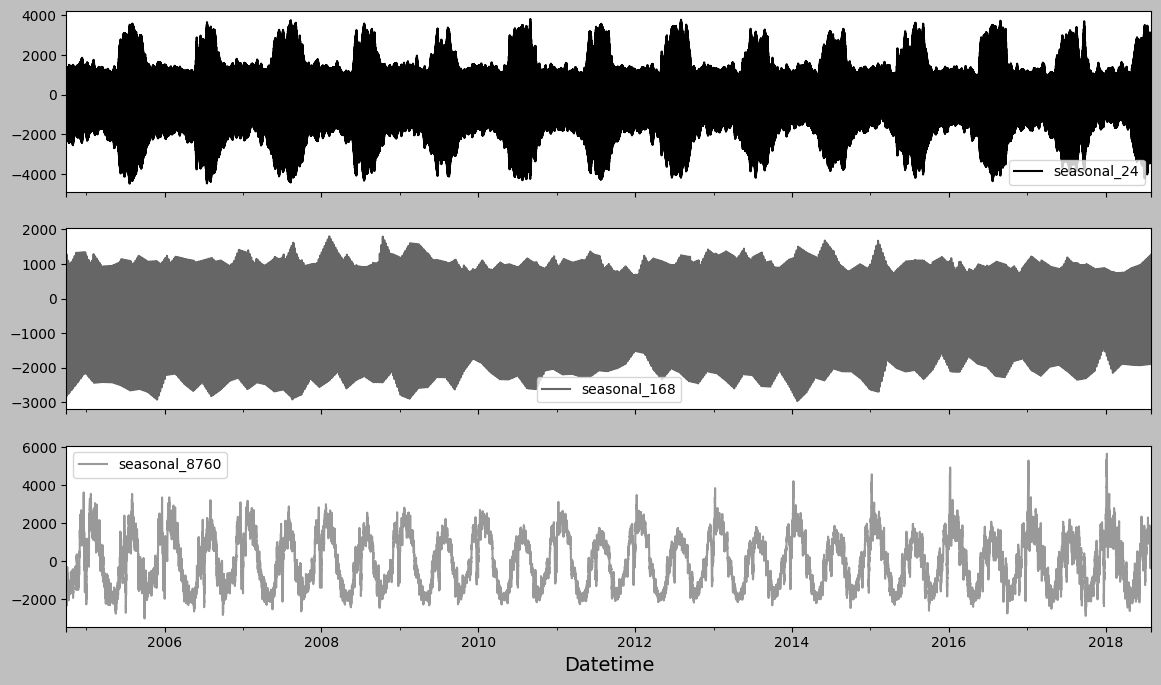

In [20]:
results.seasonal.plot(subplots=True)
plt.show()

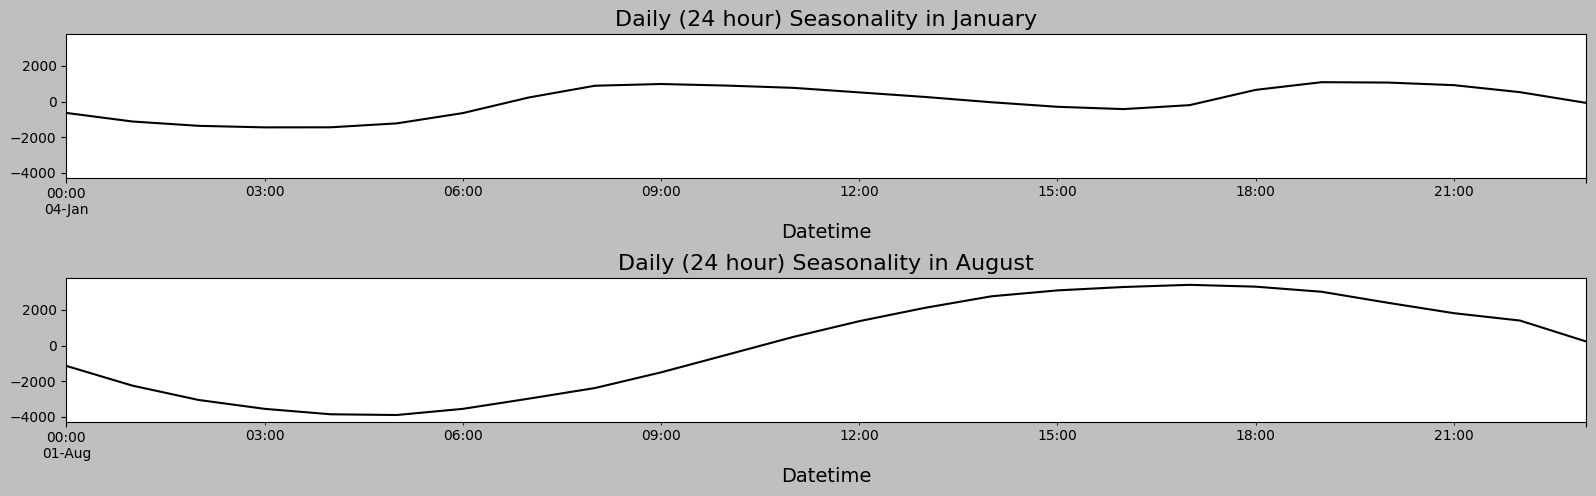

In [21]:
# mask = results.seasonal.index.month==7
fig, ax = plt.subplots(2, 1, figsize=(16, 5), sharey=True)
(results.seasonal['seasonal_24']
         .loc['2016-01-04']
         .plot(ax=ax[0], 
               title='Daily (24 hour) Seasonality in January'))
(results.seasonal['seasonal_24']
         .loc['2016-08-01']
         .plot(ax=ax[1], 
               title='Daily (24 hour) Seasonality in August'))
fig.tight_layout()
plt.show()

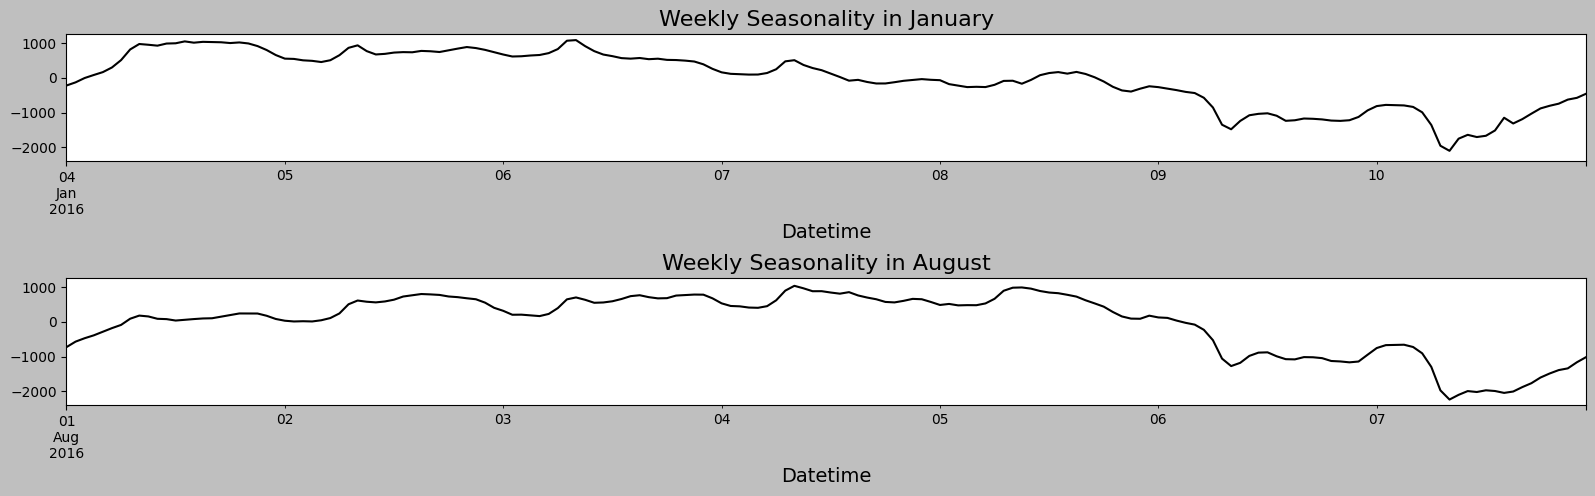

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5), sharey=True)
(results.seasonal['seasonal_168']
         .loc['2016-01-04':'2016-01-10']
         .plot(ax=ax[0], 
               title='Weekly Seasonality in January'))
(results.seasonal['seasonal_168']
         .loc['2016-08-01':'2016-08-7']
         .plot(ax=ax[1], 
               title='Weekly Seasonality in August'))
fig.tight_layout()
plt.show()

<Axes: title={'center': 'Annual Seasonality in 2016'}, xlabel='Datetime'>

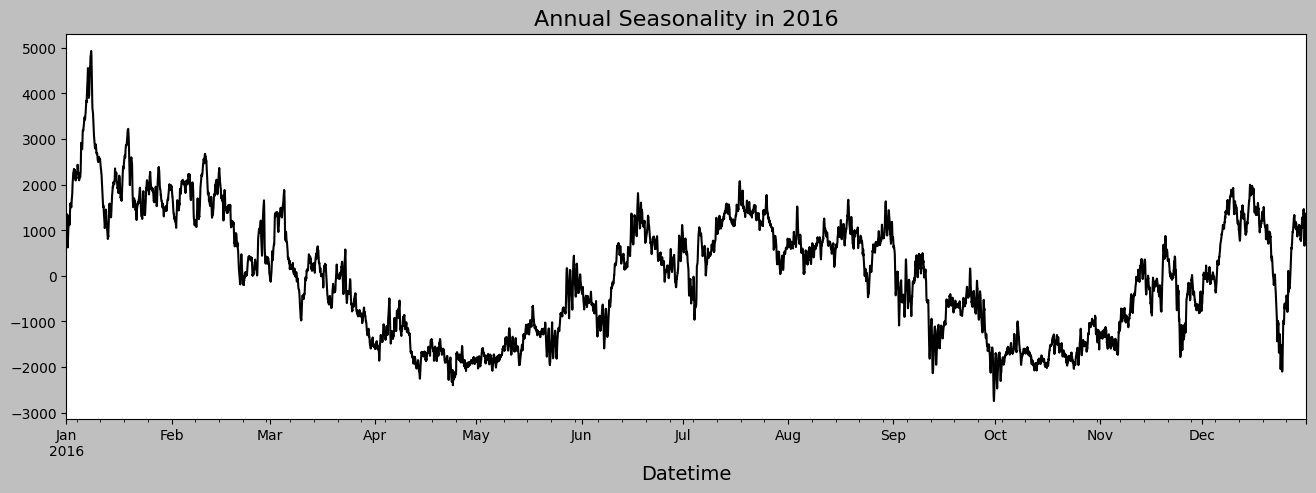

In [23]:
# mask = results.seasonal.index.month==7
(results.seasonal['seasonal_8760']
         .loc['2016-01-01':'2016-12-31']
         .plot(title='Annual Seasonality in 2016', figsize=(16, 5)))
         

## There is more

In [24]:
# !pip install statsforecast

In [25]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

In [26]:
df.head()

,y
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [27]:
df_sf = df.copy()
df_sf.reset_index(inplace=True)
df_sf.rename(columns={'Datetime': 'ds'}, inplace=True)
df_sf['unique_id'] = 'AEP_hourly'  # Adding a unique ID for StatsForecast

df_sf.head()

,ds,y,unique_id
0,2004-10-01 01:00:00,12379.0,AEP_hourly
1,2004-10-01 02:00:00,11935.0,AEP_hourly
2,2004-10-01 03:00:00,11692.0,AEP_hourly
3,2004-10-01 04:00:00,11597.0,AEP_hourly
4,2004-10-01 05:00:00,11681.0,AEP_hourly


In [28]:
train_sf = df_sf.iloc[:-week]
test_sf = df_sf.iloc[-week:]

print(f"Train length: {len(train_sf)}")
print(f"Test length: {len(test_sf)}")

Train length: 121128
Test length: 168


In [29]:
mstl = MSTL(
    season_length=[day, week, year], # seasonalities of the time series 
    trend_forecaster=AutoARIMA() # model used to forecast trend
)

In [30]:
sf = StatsForecast(
    models=[mstl], # model used to fit each time series 
    freq='h', # frequency of the data
)

In [31]:
sf = sf.fit(df=train_sf)

In [32]:
prediction_sf = sf.predict(h=week)
prediction_sf.shape

(168, 3)

In [33]:
prediction_sf

,unique_id,ds,MSTL
0,AEP_hourly,2018-07-27 01:00:00,14188.541184
1,AEP_hourly,2018-07-27 02:00:00,13463.695860
2,AEP_hourly,2018-07-27 03:00:00,12940.830141
3,AEP_hourly,2018-07-27 04:00:00,12751.390343
4,AEP_hourly,2018-07-27 05:00:00,12806.640716
...,...,...,...
163,AEP_hourly,2018-08-02 20:00:00,18116.107045
164,AEP_hourly,2018-08-02 21:00:00,17525.735868
165,AEP_hourly,2018-08-02 22:00:00,17118.365043
166,AEP_hourly,2018-08-02 23:00:00,15994.318103


In [34]:
mae_sf = mae(test_sf['y'], prediction_sf['MSTL'])
rmse_sf = rmse(test_sf['y'], prediction_sf['MSTL'])
print(f'StatsForecast MSTL MAE: {mae_sf}')
print(f'StatsForecast MSTL RMSE: {rmse_sf}')

StatsForecast MSTL MAE: 595.5968350837347
StatsForecast MSTL RMSE: 765.4766827088126


In [35]:
prediction_sf

,unique_id,ds,MSTL
0,AEP_hourly,2018-07-27 01:00:00,14188.541184
1,AEP_hourly,2018-07-27 02:00:00,13463.695860
2,AEP_hourly,2018-07-27 03:00:00,12940.830141
3,AEP_hourly,2018-07-27 04:00:00,12751.390343
4,AEP_hourly,2018-07-27 05:00:00,12806.640716
...,...,...,...
163,AEP_hourly,2018-08-02 20:00:00,18116.107045
164,AEP_hourly,2018-08-02 21:00:00,17525.735868
165,AEP_hourly,2018-08-02 22:00:00,17118.365043
166,AEP_hourly,2018-08-02 23:00:00,15994.318103


In [36]:
test_sf

,ds,y,unique_id
121128,2018-07-27 01:00:00,14057.0,AEP_hourly
121129,2018-07-27 02:00:00,13320.0,AEP_hourly
121130,2018-07-27 03:00:00,12846.0,AEP_hourly
121131,2018-07-27 04:00:00,12512.0,AEP_hourly
121132,2018-07-27 05:00:00,12533.0,AEP_hourly
...,...,...,...
121291,2018-08-02 20:00:00,17673.0,AEP_hourly
121292,2018-08-02 21:00:00,17303.0,AEP_hourly
121293,2018-08-02 22:00:00,17001.0,AEP_hourly
121294,2018-08-02 23:00:00,15964.0,AEP_hourly


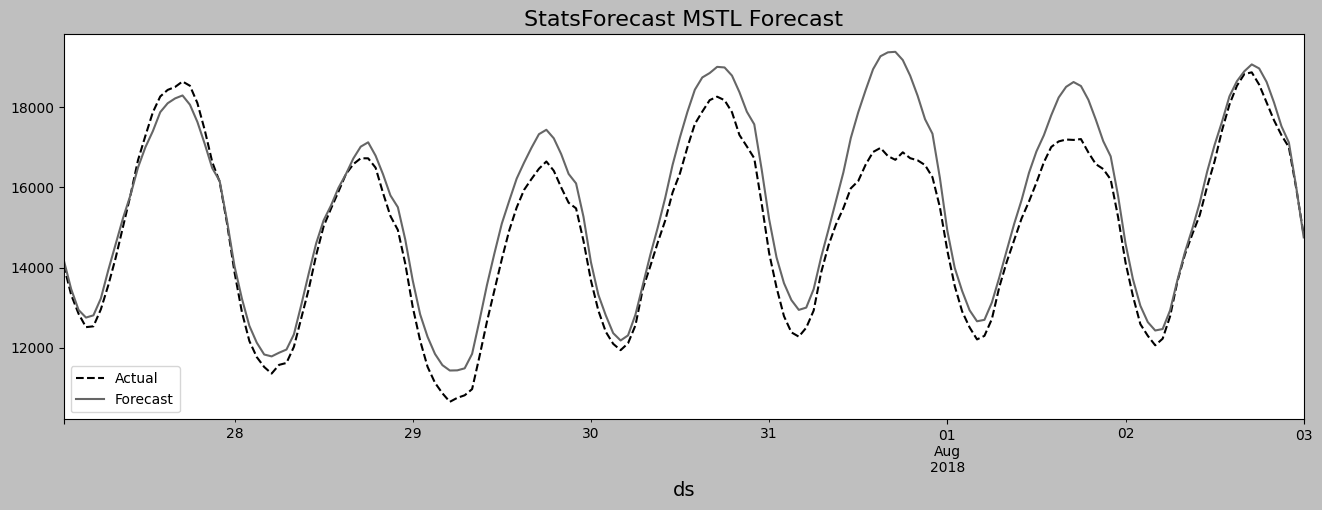

In [37]:
test_sf.set_index('ds')['y'].plot(label='Actual', figsize=(16, 5), style='--')
prediction_sf.set_index('ds')['MSTL'].plot(label='Forecast')
plt.legend()
plt.title('StatsForecast MSTL Forecast')
plt.show()


# Forecasting Time Series with Multiple Seasonality Unobserved Components using (UCM)

In [38]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
plt.rcParams["figure.figsize"] = [14, 4]

In [39]:
pd.date_range('2004-10-01 01:00:00', '2018-08-03 00:00:00', freq='H')

DatetimeIndex(['2004-10-01 01:00:00', '2004-10-01 02:00:00',
               '2004-10-01 03:00:00', '2004-10-01 04:00:00',
               '2004-10-01 05:00:00', '2004-10-01 06:00:00',
               '2004-10-01 07:00:00', '2004-10-01 08:00:00',
               '2004-10-01 09:00:00', '2004-10-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', length=121296, freq='h')

### Splitting the data

In [40]:
day = 24
week = day*7
year = day*365

train = df.iloc[:-week]
test = df.iloc[-week:]

In [41]:
train

,y
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-07-26 20:00:00,19006.0
2018-07-26 21:00:00,18322.0
2018-07-26 22:00:00,17804.0


In [42]:
test

,y
Datetime,
2018-07-27 01:00:00,14057.0
2018-07-27 02:00:00,13320.0
2018-07-27 03:00:00,12846.0
2018-07-27 04:00:00,12512.0
2018-07-27 05:00:00,12533.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [43]:
print(len(df))
print(len(train))
print(len(test))
print(len(test)/len(df.loc['2013':])*100)

121296
121128
168
0.3431302465227426


In [44]:
len(test) + len(train) == len(df)

True

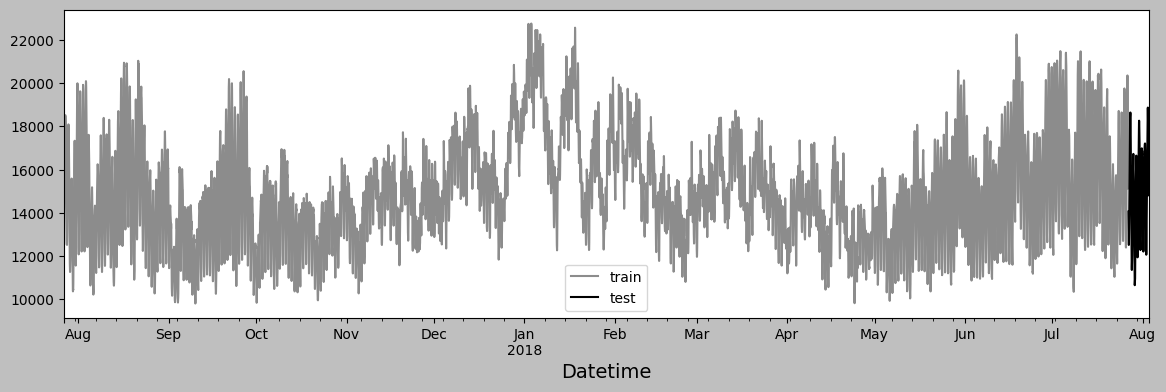

In [45]:
ax = train.iloc[-year:].plot(style='k-', alpha=0.45)
test.plot(ax=ax, style='k')
plt.legend(['train', 'test'])
plt.show()

<Axes: xlabel='Datetime'>

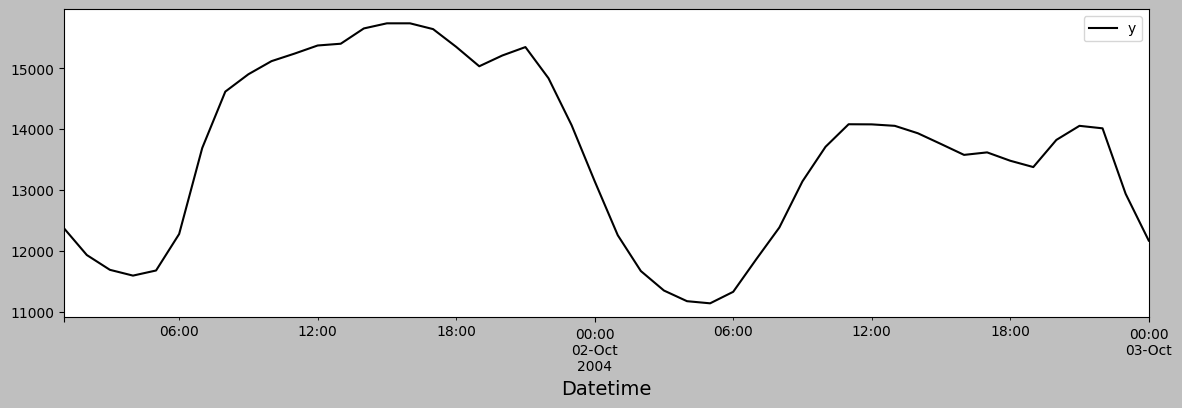

In [47]:
train.iloc[:day*2].plot()

<Axes: xlabel='Datetime'>

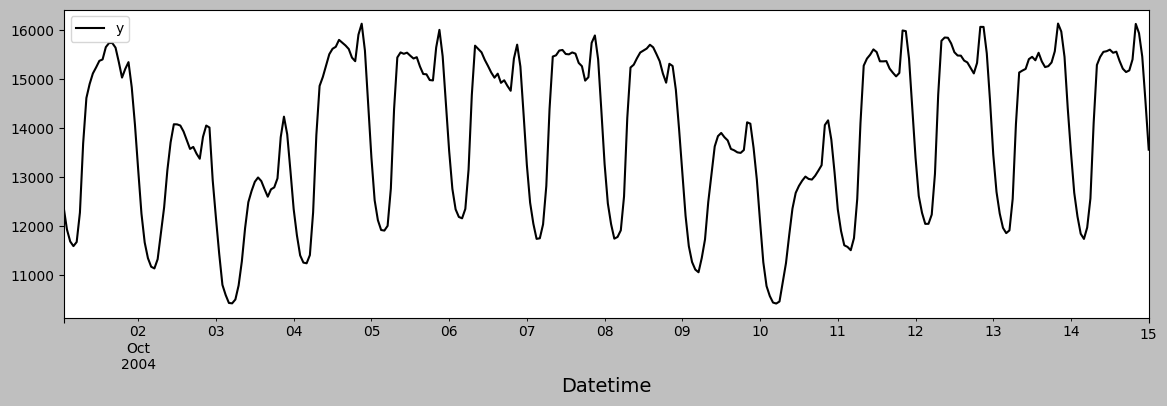

In [48]:
train.iloc[:week*2].plot()

<Axes: xlabel='Datetime'>

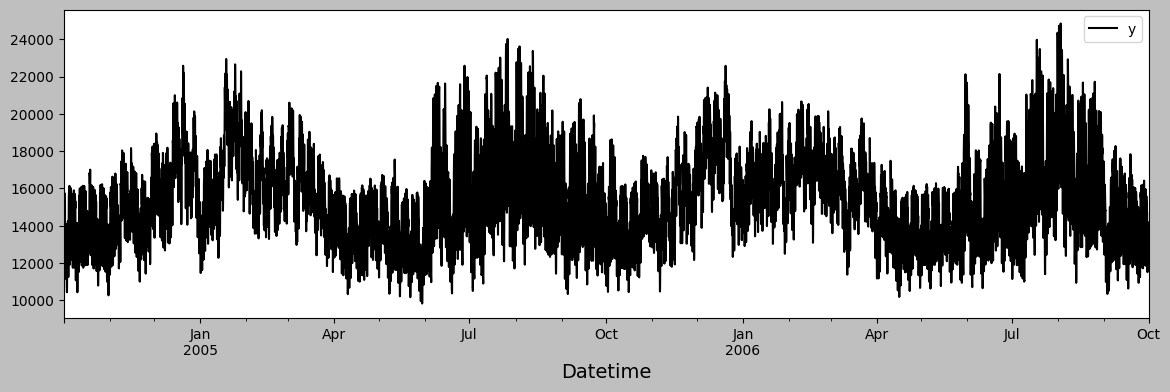

In [49]:
train.iloc[:year*2].plot()

### UCM Model

In [50]:
%%time
params = {'level':'local linear trend', # stochastic level & trend
        'irregular':True,
        'freq_seasonal':[{'period': day, 'harmonics': 4}, 
                        {'period': week, 'harmonics': 6}, 
                        {'period': year, 'harmonics': 8}],
        'stochastic_freq_seasonal':[True, True, False]} # annual kept deterministic

model = UnobservedComponents(train, **params)
                                        

results = model.fit()

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch15/dev1/lib/python3.12/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


CPU times: user 10min 26s, sys: 7.72 s, total: 10min 33s
Wall time: 10min 38s


In [51]:
results

In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                                      y   No. Observations:               121128
Model:                             local linear trend   Log Likelihood             -841583.487
                    + stochastic freq_seasonal(24(4))   AIC                        1683176.975
                   + stochastic freq_seasonal(168(6))   BIC                        1683225.496
                             + freq_seasonal(8760(8))   HQIC                       1683191.574
Date:                                Wed, 08 Oct 2025                                         
Time:                                        23:41:07                                         
Sample:                                    10-01-2004                                         
                                         - 07-27-2018                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular                0.0013     72.808   1.78e-05      1.000    -142.700     142.703
sigma2.level                 5.214e+04    258.589    201.652      0.000    5.16e+04    5.27e+04
sigma2.trend                 3.644e-10      0.000   1.54e-06      1.000      -0.000       0.000
sigma2.freq_seasonal_24(4)    149.4271      2.627     56.871      0.000     144.277     154.577
sigma2.freq_seasonal_168(6)     0.0056      0.004      1.569      0.117      -0.001       0.013
===================================================================================
Ljung-Box (L1) (Q):                9172.95   Jarque-Bera (JB):           9529099.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Performance and Analysis

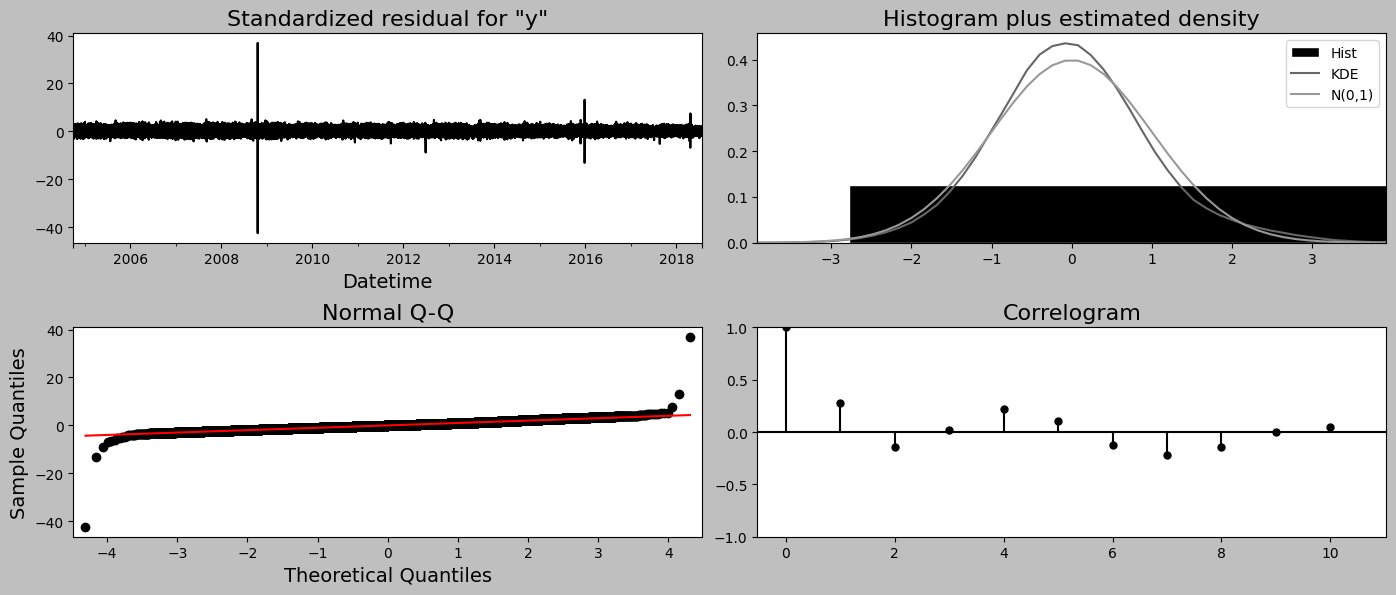

In [53]:
fig = results.plot_diagnostics(figsize=(14, 6))
fig.tight_layout()

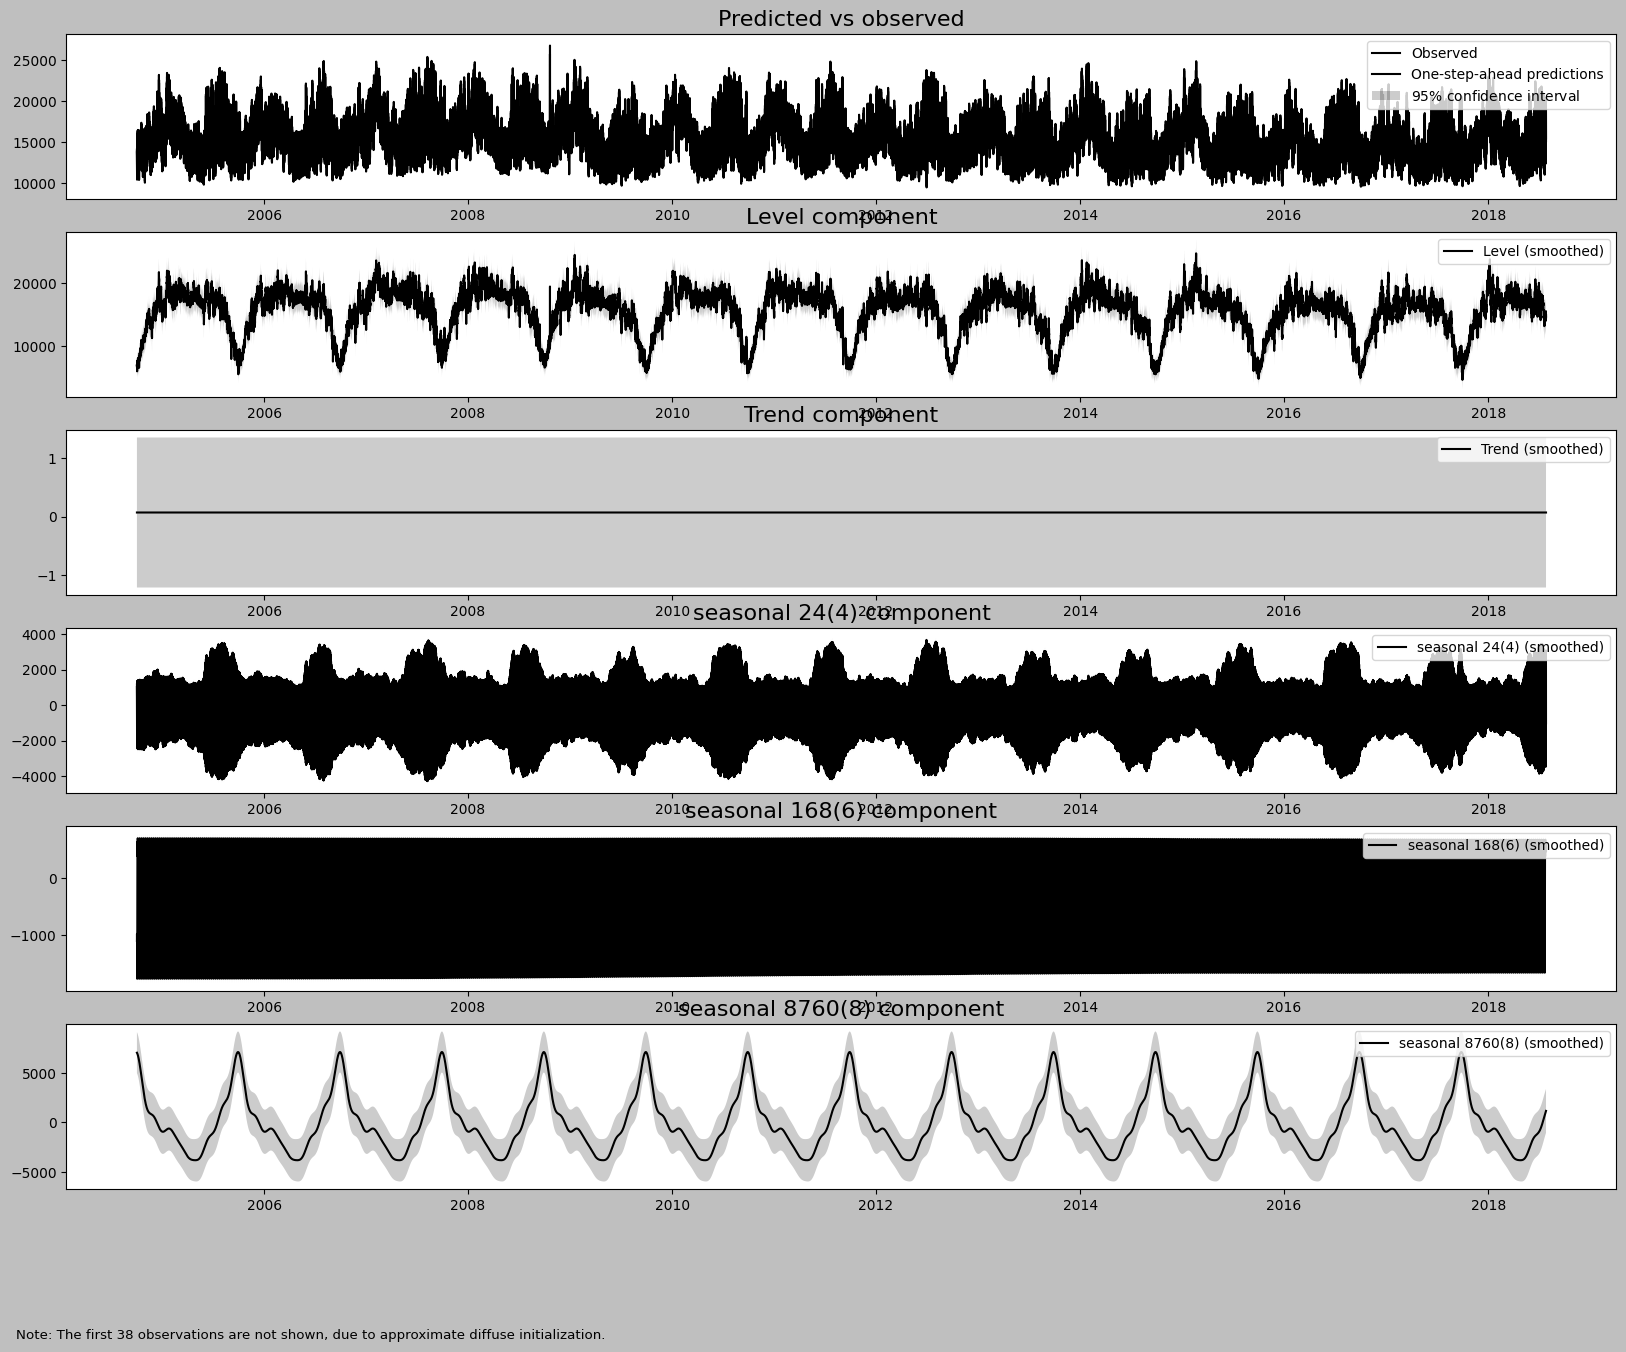

In [54]:
results.plot_components(figsize=(20, 15), 
                              freq_seasonal=True, 
                              which='smoothed')
fig.tight_layout()

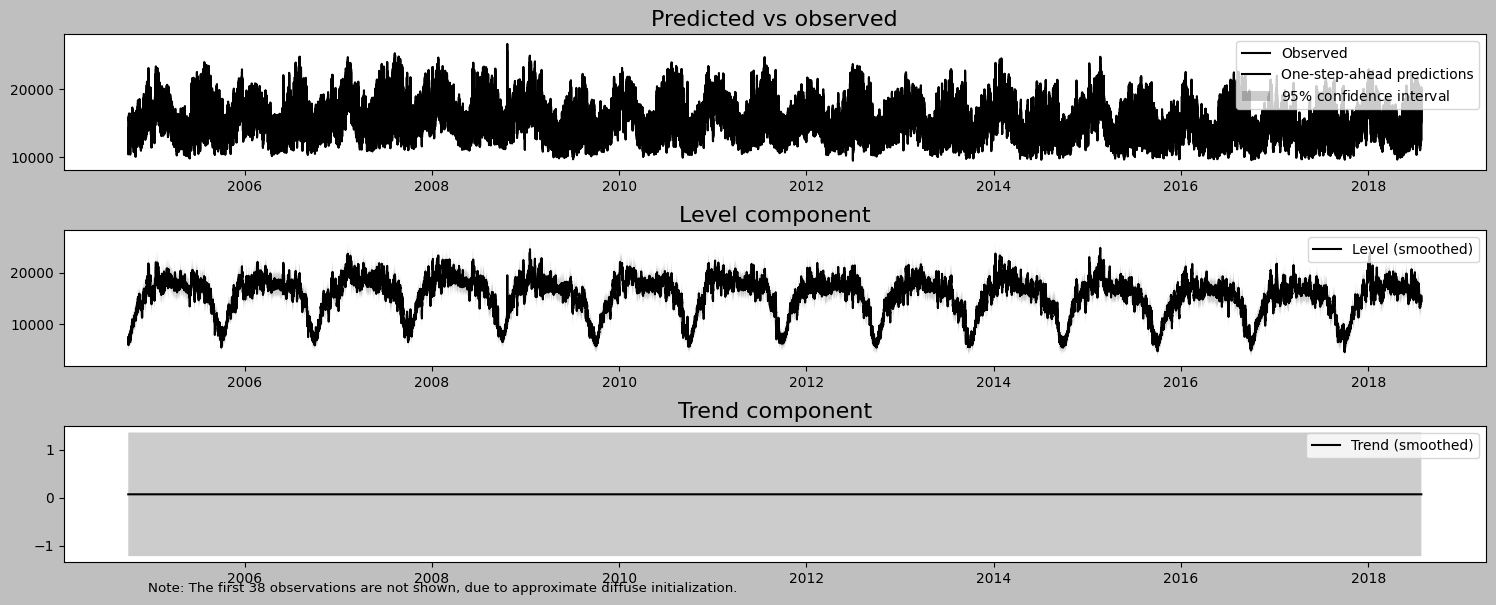

In [55]:
fig = results.plot_components(figsize=(15, 6), 
                              freq_seasonal=False, 
                              which='smoothed')
fig.tight_layout()

available `.fit()` methods. Default is `lbfgs`
```
    'newton' for Newton-Raphson
    'nm' for Nelder-Mead
    'bfgs' for Broyden-Fletcher-Goldfarb-Shanno (BFGS)
    'lbfgs' for limited-memory BFGS with optional box constraints
    'powell' for modified Powell's method
    'cg' for conjugate gradient
    'ncg' for Newton-conjugate gradient
    'basinhopping' for global basin-hopping solver
 ```

In [56]:
len(results.freq_seasonal)

3

In [57]:
len(results.freq_seasonal[0])

6

In [58]:
results.freq_seasonal[1].keys()

dict_keys(['filtered', 'filtered_cov', 'smoothed', 'smoothed_cov', 'offset', 'pretty_name'])

In [59]:
results.freq_seasonal[0]['smoothed'].shape

(121128,)

In [60]:
train.shape

(121128, 1)

<Axes: title={'center': 'Daily Seasonality'}, xlabel='hour_of_day'>

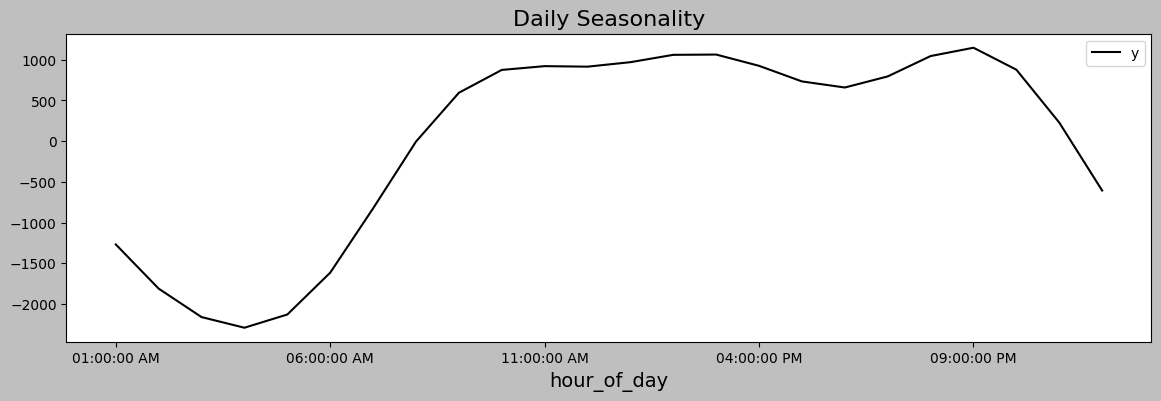

In [61]:
daily = pd.DataFrame(results.freq_seasonal[0]['smoothed'], 
                        index=train.index, columns=['y']).iloc[:day]
daily['hour_of_day'] = daily.index.strftime(date_format = '%I:%M:%S %p')
daily.plot(y='y', x='hour_of_day', title='Daily Seasonality')

<Axes: title={'center': 'Weekly Seasonality'}, xlabel='day_name'>

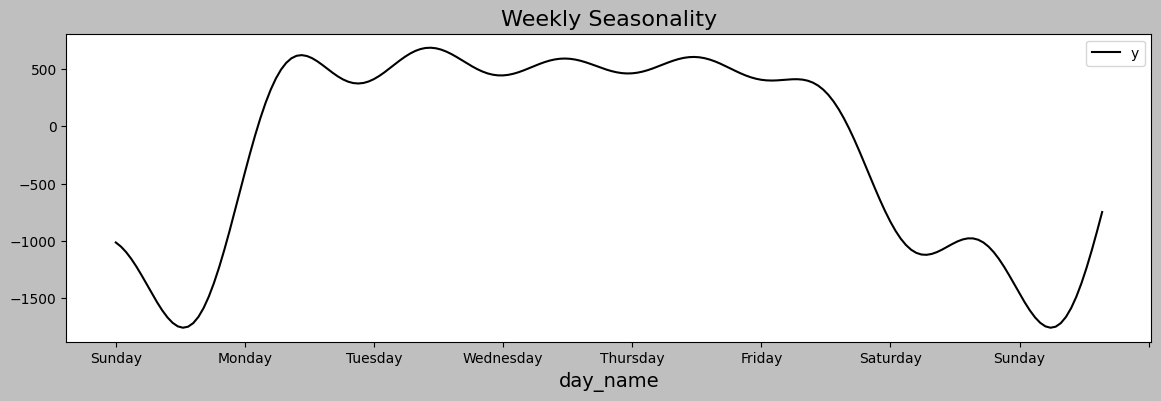

In [62]:
weekly = pd.DataFrame(results.freq_seasonal[1]['smoothed'], 
                         index=train.index, columns=['y']).loc['2004-10-03': '2004-10-10']
weekly['day_name'] = weekly.index.strftime(date_format = '%A')
weekly.plot(y='y', x='day_name', title='Weekly Seasonality')

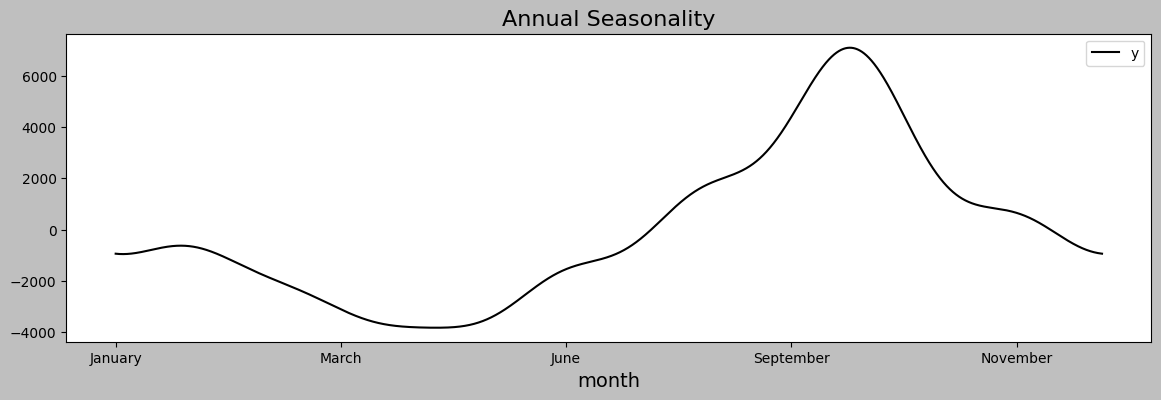

In [63]:
annual = pd.DataFrame(results.freq_seasonal[2]['smoothed'], 
                         index=train.index, columns=['y']).loc['2005']
annual['month'] = annual.index.strftime(date_format = '%B')
ax = annual.plot(y='y', x='month', title='Annual Seasonality')

In [64]:
results.freq_seasonal[2]

{'filtered': array([5212.21052596, 5243.81989191, 5884.02998988, ..., 1143.89342358,
        1147.59189819, 1151.23762064]),
 'filtered_cov': array([7578947.3684498 , 7571316.67979159, 7523216.2663166 , ...,
        1278575.81785162, 1278514.5871307 , 1278453.2550465 ]),
 'smoothed': array([7072.2425945 , 7071.30021584, 7070.32987587, ..., 1144.06578069,
        1147.65484016, 1151.23762064]),
 'smoothed_cov': array([1116779.15219593, 1116781.63535648, 1116784.72589699, ...,
        1278575.46849536, 1278514.41246845, 1278453.2550465 ]),
 'offset': 22,
 'pretty_name': 'seasonal 8760(8)'}

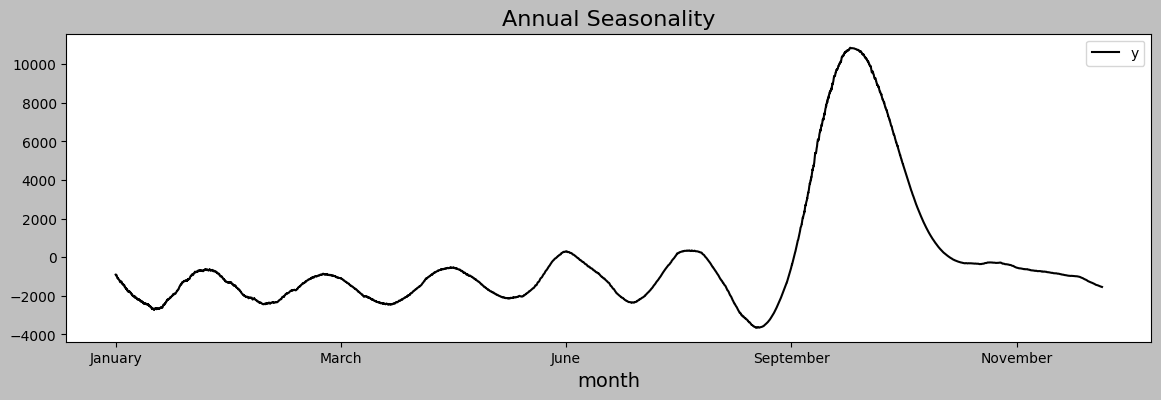

In [65]:
annual = pd.DataFrame(results.freq_seasonal[2]['filtered'], 
                         index=train.index, columns=['y']).loc['2005']
annual['month'] = annual.index.strftime(date_format = '%B')
ax = annual.plot(y='y', x='month', title='Annual Seasonality')

In [66]:
prediction = results.predict(start=test.index.min(), 
                end=test.index.max())

Text(0.5, 1.0, 'Out-of-Sample Forecast: Actual vs Predicted')

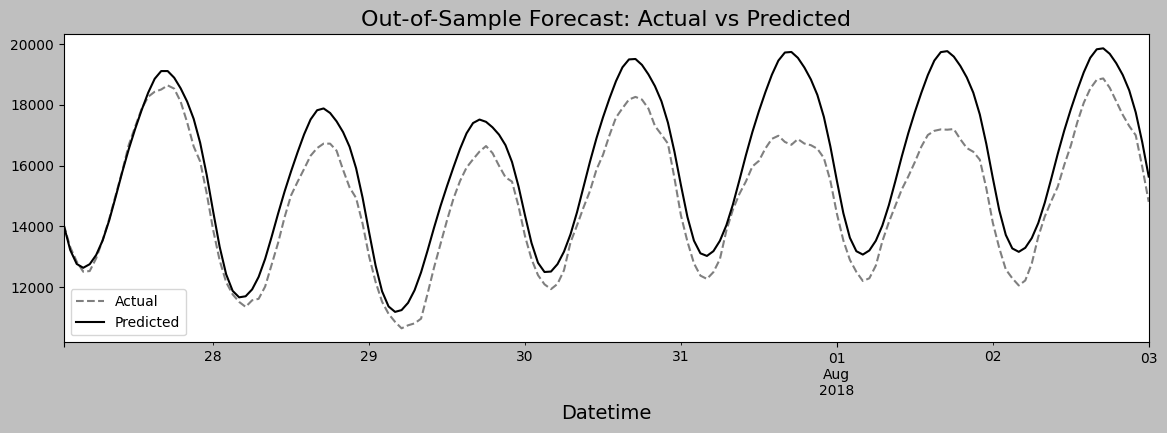

In [67]:
test.plot(style='k--', alpha=0.5)
prediction.plot(style='k')
plt.legend(['Actual', 'Predicted'])
plt.title('Out-of-Sample Forecast: Actual vs Predicted')

In [68]:
mae_ucm = mae(test['y'], prediction)
rmse_ucm = rmse(test['y'], prediction)
print(f'UCM MAE: {mae_ucm}')
print(f'UCM RMSE: {rmse_ucm}')

UCM MAE: 969.1994284493458
UCM RMSE: 1146.9518890074814


## There is more

In [69]:
params

{'level': 'local linear trend',
 'irregular': True,
 'freq_seasonal': [{'period': 24, 'harmonics': 4},
  {'period': 168, 'harmonics': 6},
  {'period': 8760, 'harmonics': 8}],
 'stochastic_freq_seasonal': [True, True, False]}

In [ ]:
df_exog = df.copy()
df_exog['is_weekend'] = df_exog.index.weekday.isin([5, 6]).astype(int)

# Re-split the data to include the new column
train_exog = df_exog.iloc[:-week]
test_exog = df_exog.iloc[-week:]

In [71]:
# Add an AR(1) component to our previous model
params['autoregressive'] = 1


model_exog_ar = UnobservedComponents(train_exog['y'],
                                exog=train_exog[['is_weekend']], 
                                **params)
                                        

results_exog_ar = model_exog_ar.fit()

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch15/dev1/lib/python3.12/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch15/dev1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [72]:
results_exog_ar.summary()

Dep. Variable:,y,No. Observations:,121128
Model:,local linear trend,Log Likelihood,-841602.223
,+ stochastic freq_seasonal(24(4)),AIC,1683220.446
,+ stochastic freq_seasonal(168(6)),BIC,1683298.080
,+ freq_seasonal(8760(8)),HQIC,1683243.805
,+ AR(1),,
Date:,"Thu, 09 Oct 2025",,
Time:,00:10:43,,
Sample:,10-01-2004,,
,- 07-27-2018,,
Covariance Type:,opg,,


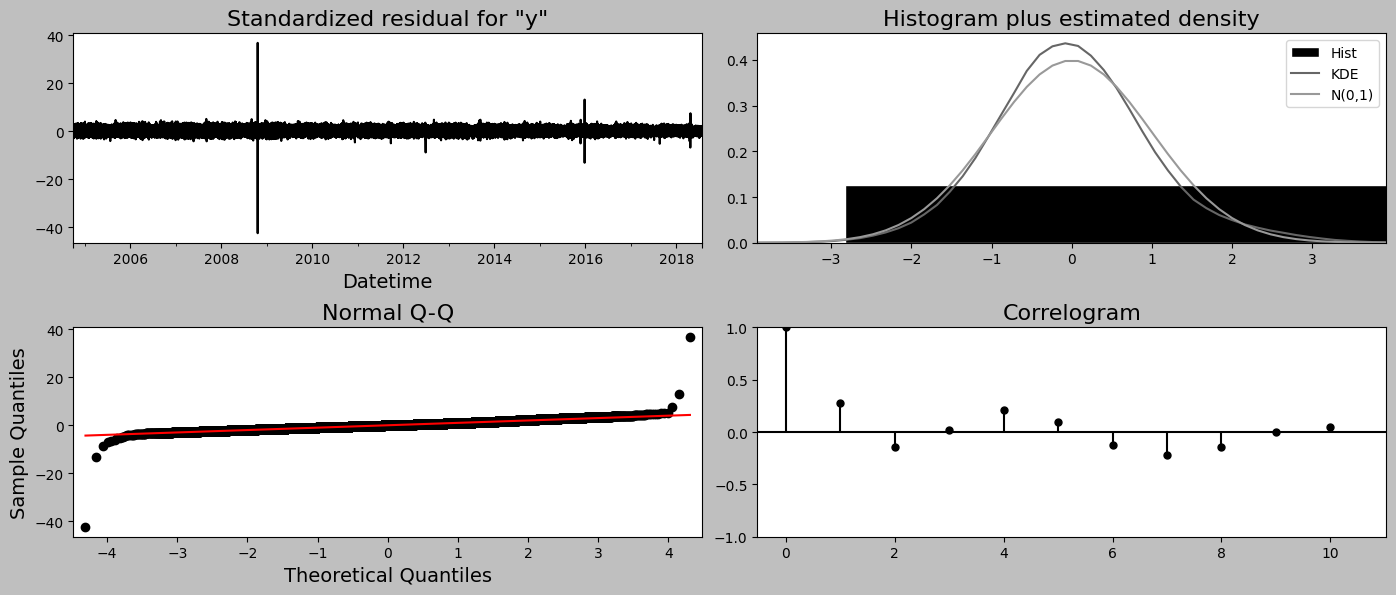

In [73]:
fig = results_exog_ar.plot_diagnostics(figsize=(14, 6))
fig.tight_layout()

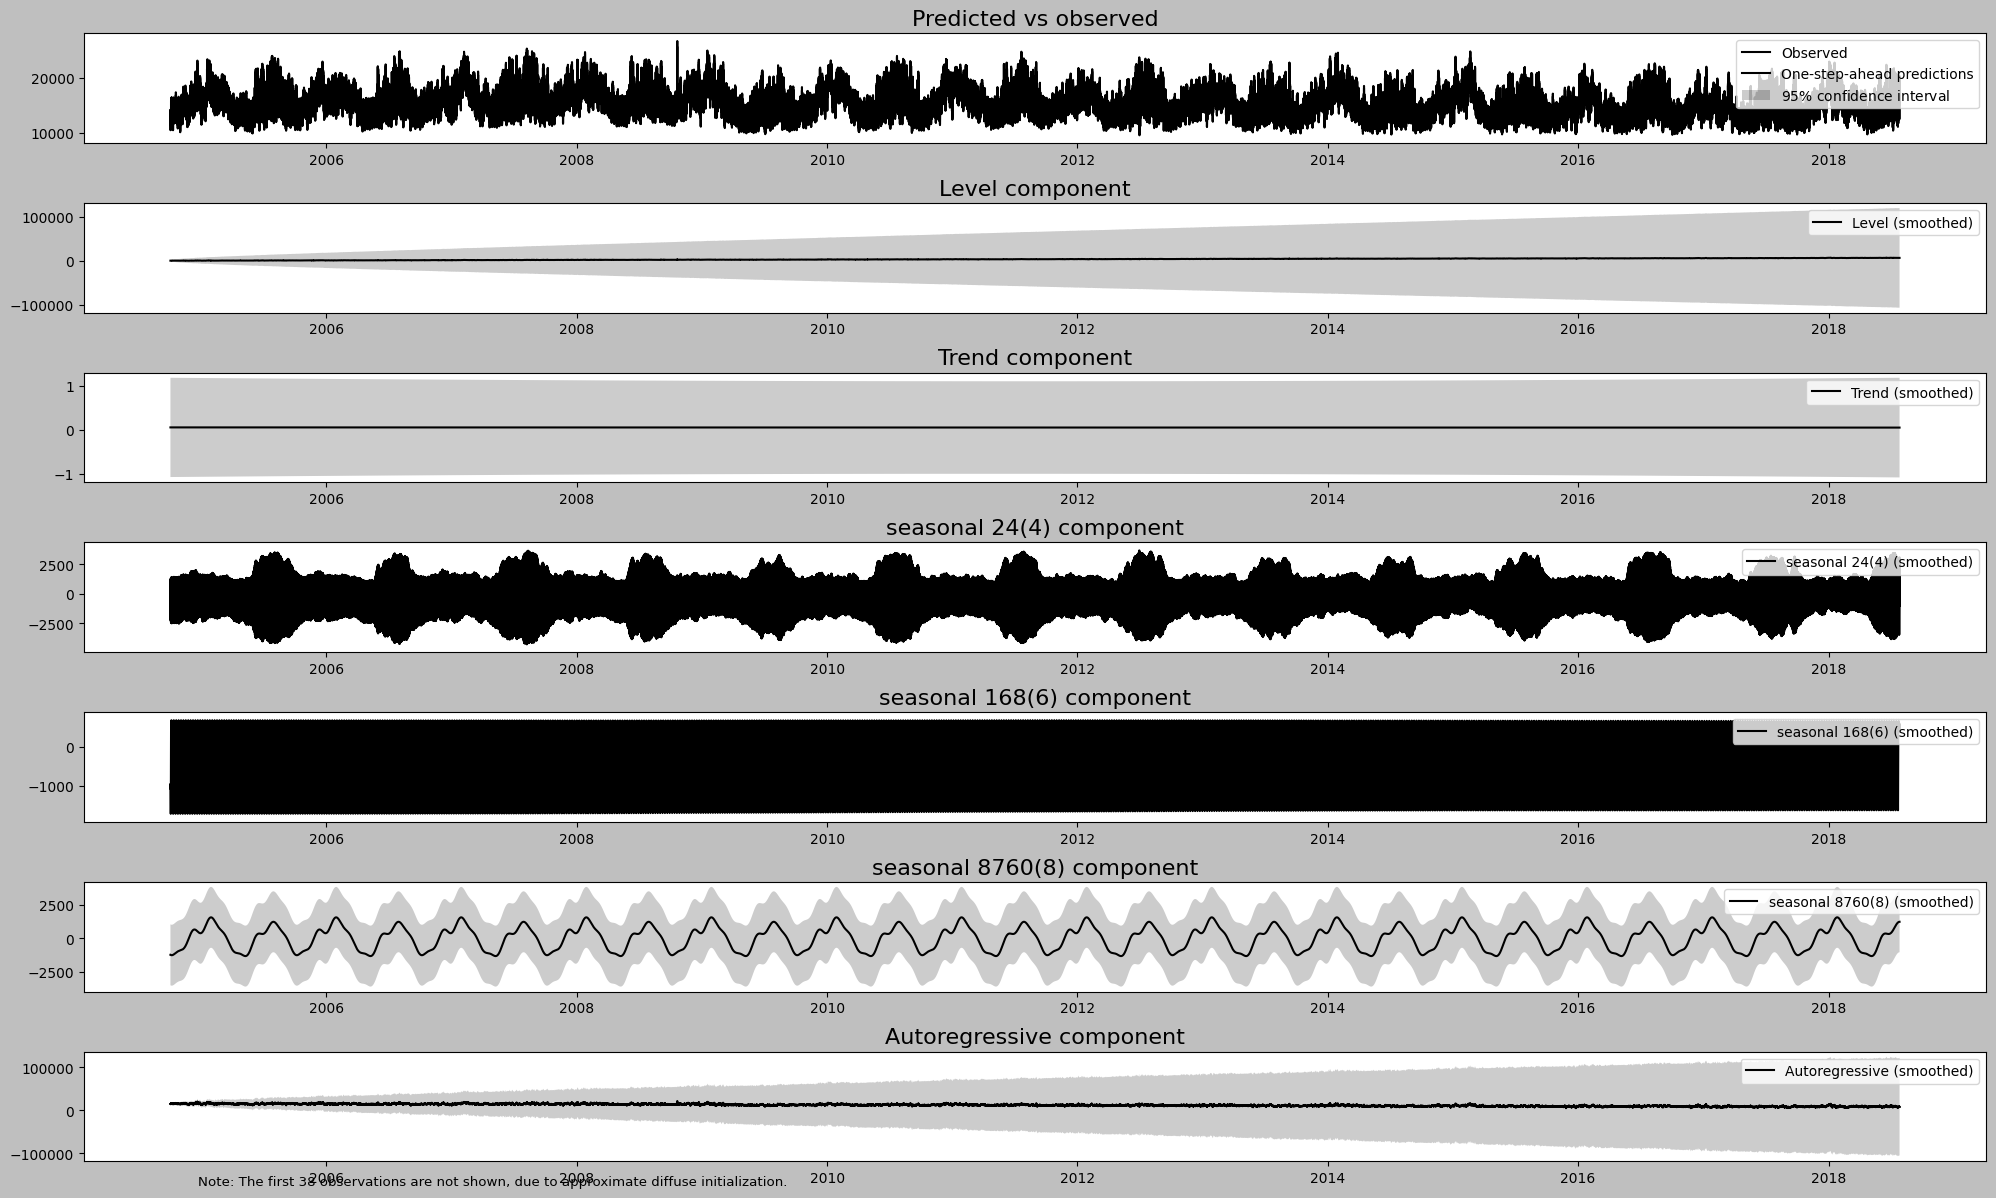

In [74]:
fig = results_exog_ar.plot_components(figsize=(20, 12), 
                              which='smoothed')
fig.tight_layout()

<Axes: title={'center': 'Daily Seasonality'}, xlabel='hour_of_day'>

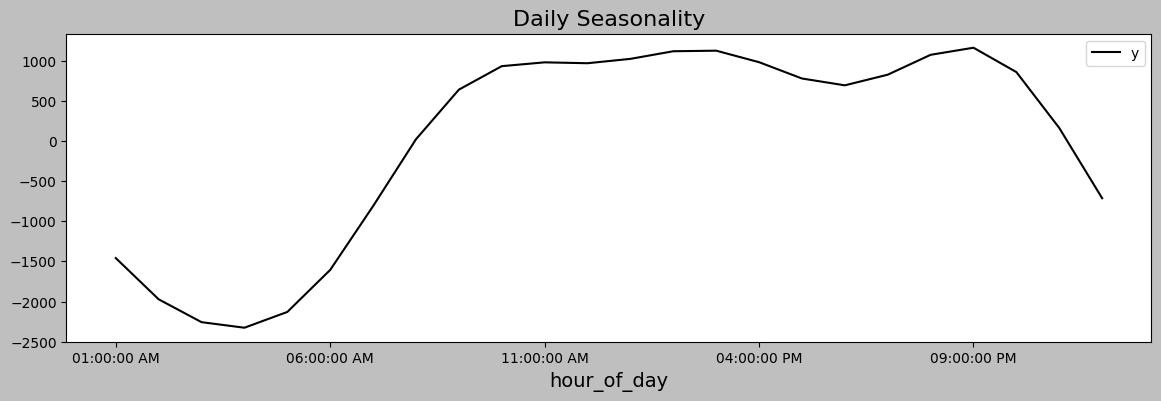

In [75]:
daily = pd.DataFrame(results_exog_ar.freq_seasonal[0]['smoothed'], 
                        index=train.index, columns=['y']).iloc[:day]
daily['hour_of_day'] = daily.index.strftime(date_format = '%I:%M:%S %p')
daily.plot(y='y', x='hour_of_day', title='Daily Seasonality')

<Axes: title={'center': 'Weekly Seasonality'}, xlabel='day_name'>

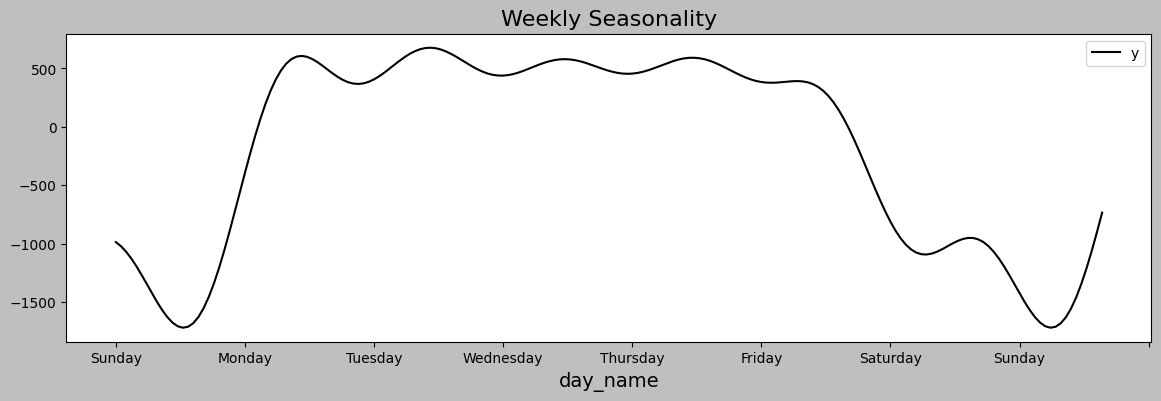

In [76]:
weekly = pd.DataFrame(results_exog_ar.freq_seasonal[1]['smoothed'], 
                         index=train.index, columns=['y']).loc['2004-10-03': '2004-10-10']
weekly['day_name'] = weekly.index.strftime(date_format = '%A')
weekly.plot(y='y', x='day_name', title='Weekly Seasonality')

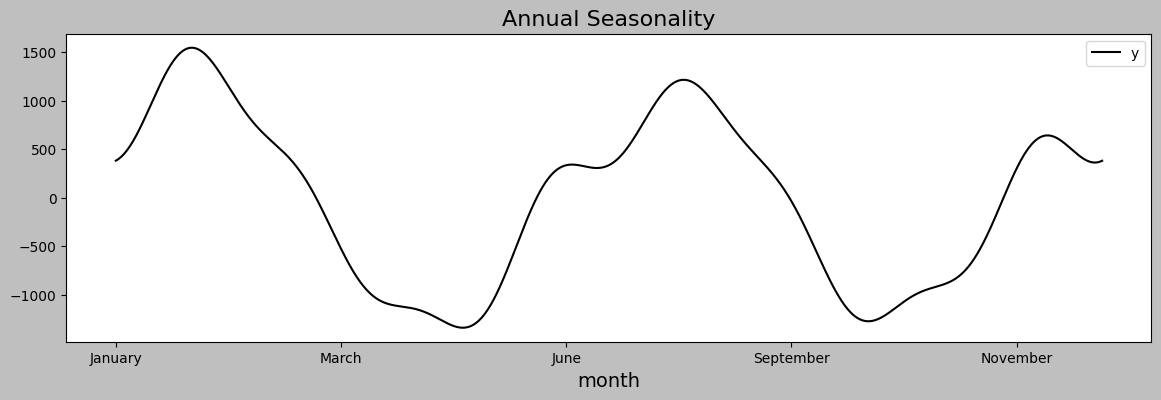

In [77]:
annual = pd.DataFrame(results_exog_ar.freq_seasonal[2]['smoothed'], 
                         index=train.index, columns=['y']).loc['2005']
annual['month'] = annual.index.strftime(date_format = '%B')
ax = annual.plot(y='y', x='month', title='Annual Seasonality')

In [78]:
prediction_exog_ar = results_exog_ar.predict(start=test_exog.index.min(),
                                             end=test_exog.index.max(),
                                             exog=test_exog['is_weekend'])

Text(0.5, 1.0, 'Out-of-Sample Forecast: Actual vs Predicted')

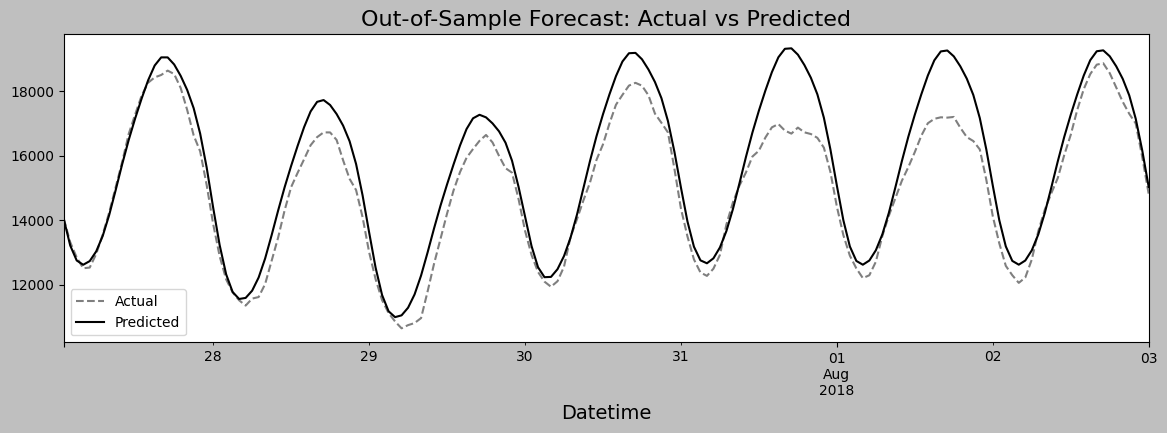

In [79]:
test.plot(style='k--', alpha=0.5)
prediction_exog_ar.plot(style='k')
plt.legend(['Actual', 'Predicted'])
plt.title('Out-of-Sample Forecast: Actual vs Predicted')

In [80]:
mae_ucm = mae(test_exog['y'], prediction_exog_ar)
rmse_ucm = rmse(test_exog['y'], prediction_exog_ar)
print(f'UCM w/AR and Exog MAE: {mae_ucm}')
print(f'UCM w/AR and Exog RMSE: {rmse_ucm}')

UCM w/AR and Exog MAE: 671.6247881171026
UCM w/AR and Exog RMSE: 856.2218023591656


# TBATS

In [10]:
# !pip install StatsForecast -q

In [81]:
from statsforecast import StatsForecast 
from statsforecast.models import AutoTBATS


In [82]:
df_sf = df.copy()
df_sf.reset_index(inplace=True)
df_sf.rename(columns={'Datetime': 'ds'}, inplace=True)
df_sf['unique_id'] = 'AEP_hourly'  # Adding a unique ID for StatsForecast


day = 24
week = day*7
year = day*365

train_sf = df_sf.iloc[:-week]
test_sf = df_sf.iloc[-week:]

In [83]:
# model multiple seasons: daily, weekly
tbats = AutoTBATS(
    season_length=[day, week],
    use_trend=None,  # None means to try both (with or without)
    use_boxcox=None,  # None means to try both (with or without)
    use_arma_errors=None,  #  None means to try both (with or without)
    use_damped_trend=None,  # None means to try both (with or without)
)


In [84]:
# hourly frequency 
sf = StatsForecast(
    models=[tbats],
    freq='H',
    n_jobs=-1
)


In [85]:
# train our model
sf.fit(train_sf)

StatsForecast(models=[AutoTBATS])

In [86]:
prediction_sf = sf.predict(h=week)
prediction_sf.shape

(168, 3)

<Axes: xlabel='ds'>

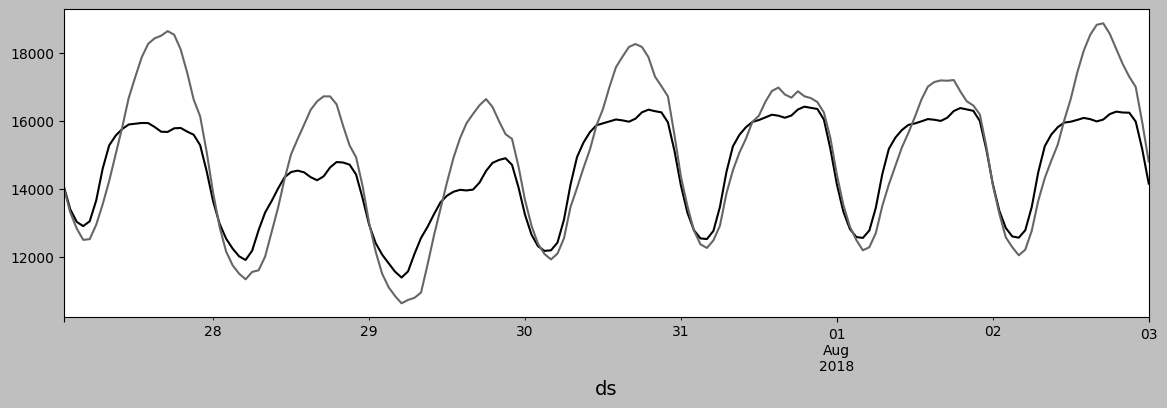

In [87]:
prediction_sf.set_index('ds')['AutoTBATS'].plot()
test_sf.set_index('ds')['y'].plot()

In [88]:
prediction_sf

,unique_id,ds,AutoTBATS
0,AEP_hourly,2018-07-27 01:00:00,14091.664533
1,AEP_hourly,2018-07-27 02:00:00,13410.781239
2,AEP_hourly,2018-07-27 03:00:00,13040.587009
3,AEP_hourly,2018-07-27 04:00:00,12915.394658
4,AEP_hourly,2018-07-27 05:00:00,13057.529499
...,...,...,...
163,AEP_hourly,2018-08-02 20:00:00,16250.180626
164,AEP_hourly,2018-08-02 21:00:00,16245.808211
165,AEP_hourly,2018-08-02 22:00:00,15984.733056
166,AEP_hourly,2018-08-02 23:00:00,15174.645035


In [89]:
mae_sf = mae(test_sf['y'], prediction_sf['AutoTBATS'])
rmse_sf = rmse(test_sf['y'], prediction_sf['AutoTBATS'])
print(f'AutoTBATS MAE: {mae_sf}')
print(f'AutoTBATS RMSE: {rmse_sf}')

AutoTBATS MAE: 868.4687534921502
AutoTBATS RMSE: 1129.4514312286358


## There's more

In [90]:
fitted_model = sf.fitted_[0][0]

In [91]:
# Now you can inspect the model's description
fitted_model.model_['description']

{'use_boxcox': True,
 'use_trend': True,
 'use_damped_trend': True,
 'use_arma_errors': False}

In [92]:
fitted = fitted_model.model_['fitted'][0]
residuals = fitted_model.model_['errors'][0]

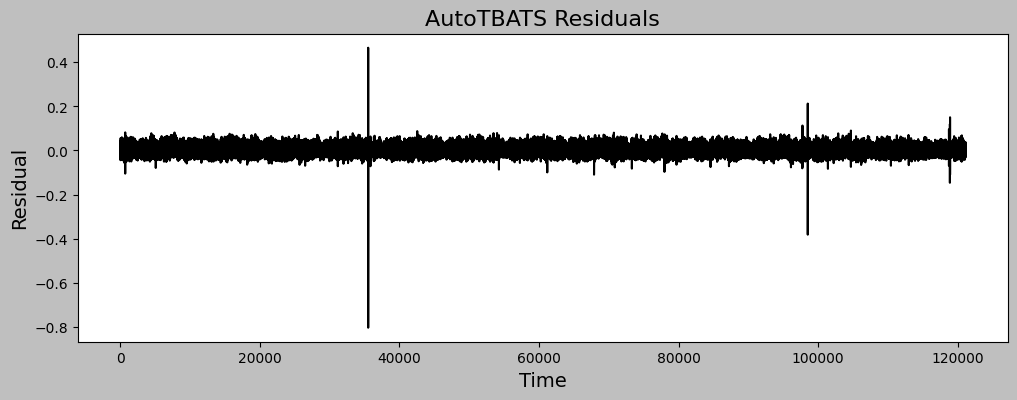

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title('AutoTBATS Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

In [94]:
p = fitted_model.model_['p']
q = fitted_model.model_['q']
print(f"ARMA's p={p} and q={q}")

ARMA's p=0 and q=0


In [95]:
fitted_model.model_['BoxCox_lambda']

0.00046153629516299167

# NeuralProphet

In [4]:
from neuralprophet import NeuralProphet, set_random_seed

set_random_seed(seed=42)

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [16]:
df_np = df.copy()
df_np.reset_index(inplace=True)
df_np.rename(columns={'Datetime': 'ds'}, inplace=True)

In [17]:
week = 24*7

train_np = df_np.iloc[:-week*2]
val_np = df_np.iloc[-week*2:-week]
test_np = df_np.iloc[-week:]
print(f"""
train_np : {len(train_np)}
val_np : {len(val_np)}
test_np: {len(test_np)}
""")


train_np : 120960
val_np : 168
test_np: 168



In [18]:
train_np.head()

,ds,y
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


In [19]:
m = NeuralProphet()
metrics = m.fit(train_np, validation_df=val_np)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as h
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 256
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 30


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 277/277 [00:04<00:00, 57.60it/s]


Training: |          | 0/? [02:21<?, ?it/s, v_num=30, MAE_val=1.16e+3, RMSE_val=1.37e+3, Loss_val=0.0282, RegLoss_val=0.000, train_loss=0.0285, reg_loss=0.000, MAE=1.23e+3, RMSE=1.6e+3, Loss=0.0285, RegLoss=0.000] 


In [20]:
forecast = m.predict(df=test_np)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.405% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.405% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - h


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.48it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


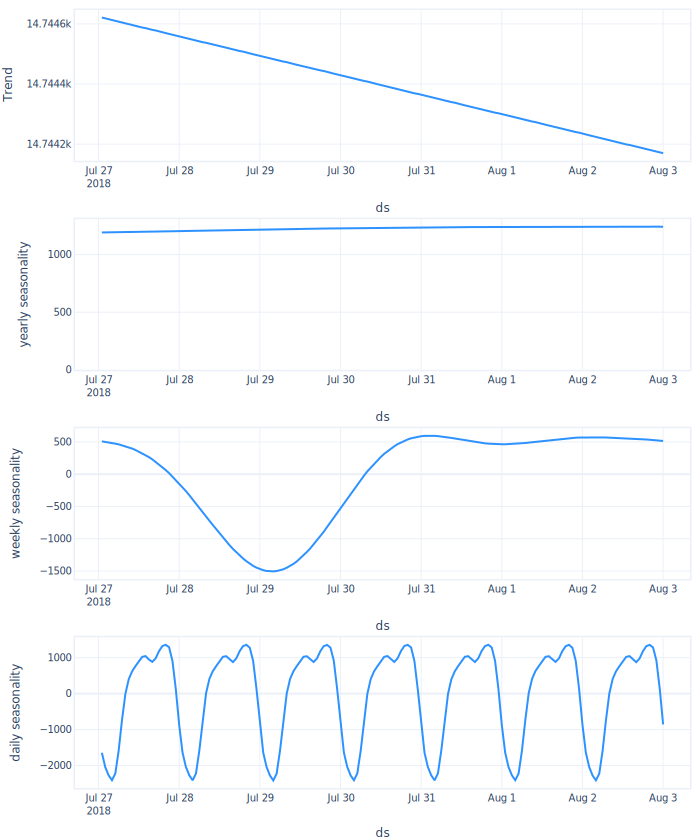

In [21]:
# Interactive plotly
# m.plot_components(forecast)

# if you are having issues rendering the interactive visualizations then use this instead
m.plot_components(forecast, plotting_backend='plotly-static')


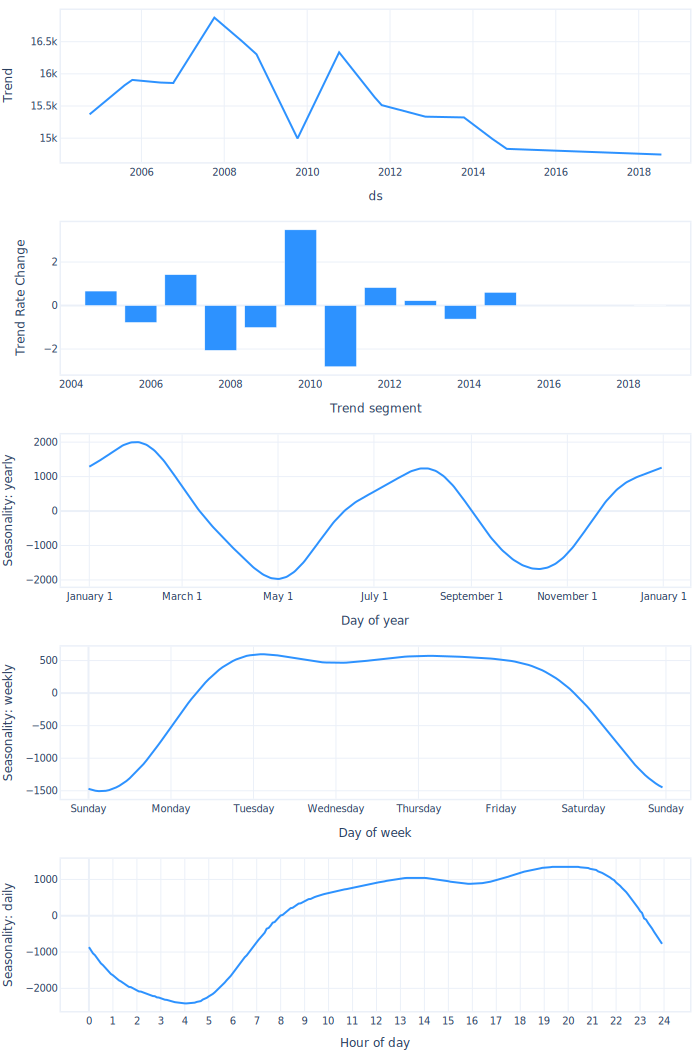

In [22]:
# Interactive plotly
# m.plot_parameters()

# if you are having issues with the interactive rendering then run this line instead
m.plot_parameters(plotting_backend='plotly-static')

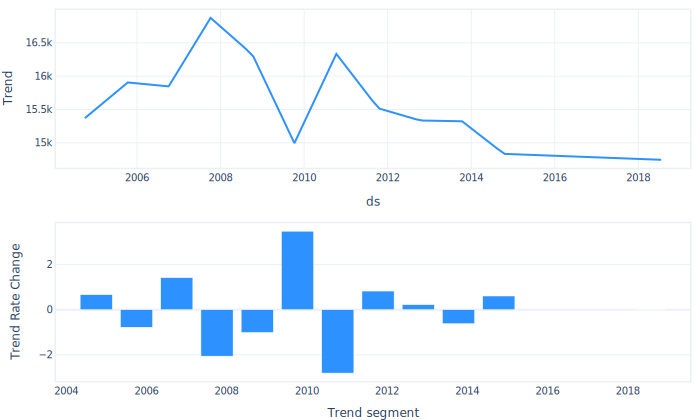

In [23]:
# interactive plotly
# m.plot_parameters(components=['Trend', 'trend_rate_change'])

# if you are having issues with the interactive rendering then run this line instead
m.plot_parameters(components=['Trend', 'trend_rate_change'], plotting_backend='plotly-static')


In [24]:
forecast.columns

Index(['ds', 'y', 'yhat1', 'trend', 'season_yearly', 'season_weekly',
       'season_daily'],
      dtype='object')

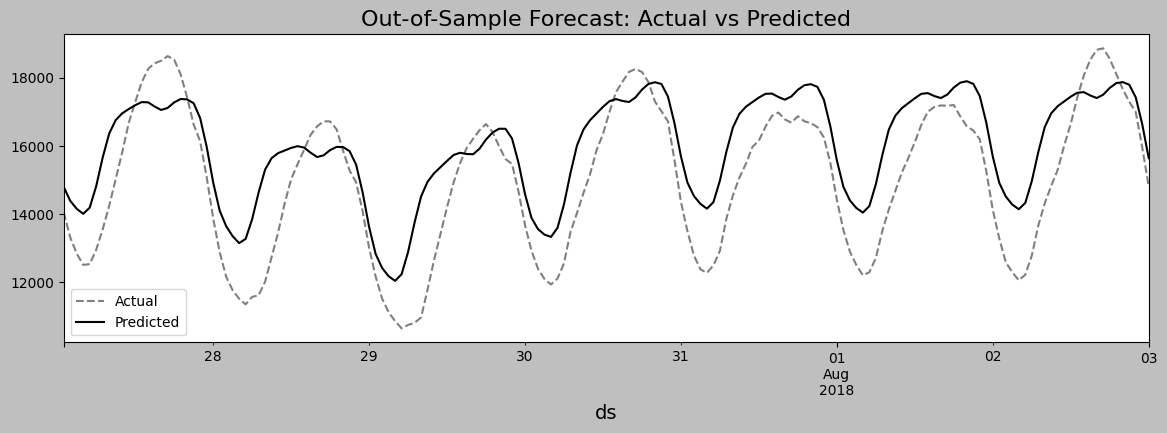

In [25]:
prediction_np = forecast.set_index('ds')['yhat1']
test_np.set_index('ds').plot(style='k--', alpha=0.5)
prediction_np.plot(style='k')
plt.legend(['Actual', 'Predicted'])
plt.title('Out-of-Sample Forecast: Actual vs Predicted')
plt.show()


In [26]:
test_results = m.test(df=test_np)
print(test_results)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.405% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - h


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.030542725697159767
         MAE_val            1236.0711669921875
        RMSE_val             1427.038818359375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       MAE_val     RMSE_val  Loss_test  RegLoss_test
0  1236.071167  1427.038818   0.030543           0.0


In [27]:
from statsmodels.tools.eval_measures import rmse, meanabs as mae

mae_np = mae(test_np['y'], prediction_np)
rmse_np = rmse(test_np['y'], prediction_np)
print(f'NeuralProphet MAE: {mae_np}')
print(f'NeuralProphet RMSE: {rmse_np}')

NeuralProphet MAE: 1236.0711553664435
NeuralProphet RMSE: 1427.0386964275483


In [28]:
metrics.columns

Index(['MAE_val', 'RMSE_val', 'Loss_val', 'RegLoss_val', 'epoch', 'train_loss',
       'reg_loss', 'MAE', 'RMSE', 'Loss', 'RegLoss'],
      dtype='object')

In [29]:
print(metrics.tail(1))

        MAE_val     RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  \
29  1164.994385  1369.922119  0.028161          0.0     29    0.028493   

    reg_loss          MAE         RMSE      Loss  RegLoss  
29       0.0  1227.644043  1598.841431  0.028484      0.0  


## There's more

In [27]:
# !uv pip install "neuralprophet[live]"

In [30]:
df_np['is_weekend'] = df_np['ds'].dt.weekday.isin([5, 6]).astype(int)
df_np

,ds,y,is_weekend
0,2004-10-01 01:00:00,12379.0,0
1,2004-10-01 02:00:00,11935.0,0
2,2004-10-01 03:00:00,11692.0,0
3,2004-10-01 04:00:00,11597.0,0
4,2004-10-01 05:00:00,11681.0,0
...,...,...,...
121291,2018-08-02 20:00:00,17673.0,0
121292,2018-08-02 21:00:00,17303.0,0
121293,2018-08-02 22:00:00,17001.0,0
121294,2018-08-02 23:00:00,15964.0,0


In [31]:
train_np = df_np.iloc[:-week*2]
val_np = df_np.iloc[-week*2:-week]
test_np = df_np.iloc[-week:]

In [32]:
m = NeuralProphet()
m.add_future_regressor("is_weekend")
m.add_country_holidays("US")

metrics = m.fit(train_np, validation_df=val_np)



WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as h
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Epoch 30: 100%|██████████| 30/30 [01:17<00:00,  0.39it/s]   


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 256
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 30


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 277/277 [00:03<00:00, 79.12it/s]


Training: |          | 0/? [02:42<?, ?it/s, v_num=31, MAE_val=1.17e+3, RMSE_val=1.37e+3, Loss_val=0.0281, RegLoss_val=0.000, train_loss=0.0284, reg_loss=0.000, MAE=1.23e+3, RMSE=1.6e+3, Loss=0.0284, RegLoss=0.000] 


In [33]:
metrics

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
0,1973.264893,2214.134033,0.073205,0.0,0,0.309783,0.0,6168.449707,7642.216309,0.309535,0.0
1,1083.405884,1276.809692,0.024463,0.0,1,0.040084,0.0,1561.198730,2008.498047,0.040069,0.0
2,1208.566162,1435.100342,0.030900,0.0,2,0.030327,0.0,1283.377319,1662.819336,0.030328,0.0
3,1065.568115,1273.219727,0.024325,0.0,3,0.029798,0.0,1263.124512,1640.652954,0.029799,0.0
4,1118.737061,1378.355591,0.028460,0.0,4,0.030150,0.0,1269.488770,1648.919678,0.030143,0.0
5,1168.342773,1399.269531,0.029380,0.0,5,0.030667,0.0,1281.691162,1663.075928,0.030672,0.0
6,1171.468628,1352.524780,0.027450,0.0,6,0.030943,0.0,1286.898315,1670.213379,0.030940,0.0
7,994.289795,1199.262085,0.021581,0.0,7,0.031043,0.0,1289.447388,1673.262451,0.031048,0.0
8,1076.836548,1348.654297,0.027269,0.0,8,0.031443,0.0,1298.936035,1683.674927,0.031448,0.0
9,1114.564209,1321.120361,0.026190,0.0,9,0.031345,0.0,1296.878052,1681.930786,0.031348,0.0


In [34]:
m.parameters()

{'growth': 'linear',
 'changepoints': None,
 'n_changepoints': 10,
 'changepoints_range': 0.8,
 'trend_reg': 0,
 'trend_reg_threshold': False,
 'trend_global_local': 'global',
 'trend_local_reg': False,
 'yearly_seasonality': 'auto',
 'yearly_seasonality_glocal_mode': 'auto',
 'weekly_seasonality': 'auto',
 'weekly_seasonality_glocal_mode': 'auto',
 'daily_seasonality': 'auto',
 'daily_seasonality_glocal_mode': 'auto',
 'seasonality_mode': 'additive',
 'seasonality_reg': 0,
 'season_global_local': 'global',
 'seasonality_local_reg': False,
 'future_regressors_model': 'linear',
 'future_regressors_d_hidden': 4,
 'future_regressors_num_hidden_layers': 2,
 'n_forecasts': 1,
 'n_lags': 0,
 'ar_layers': [],
 'ar_reg': None,
 'lagged_reg_layers': [],
 'learning_rate': None,
 'epochs': None,
 'batch_size': None,
 'loss_func': 'SmoothL1Loss',
 'optimizer': 'AdamW',
 'newer_samples_weight': 2,
 'newer_samples_start': 0.0,
 'quantiles': [],
 'impute_missing': True,
 'impute_linear': 10,
 'impute

In [35]:
forecast_exog = m.predict(test_np)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.405% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.405% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - h


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.34it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


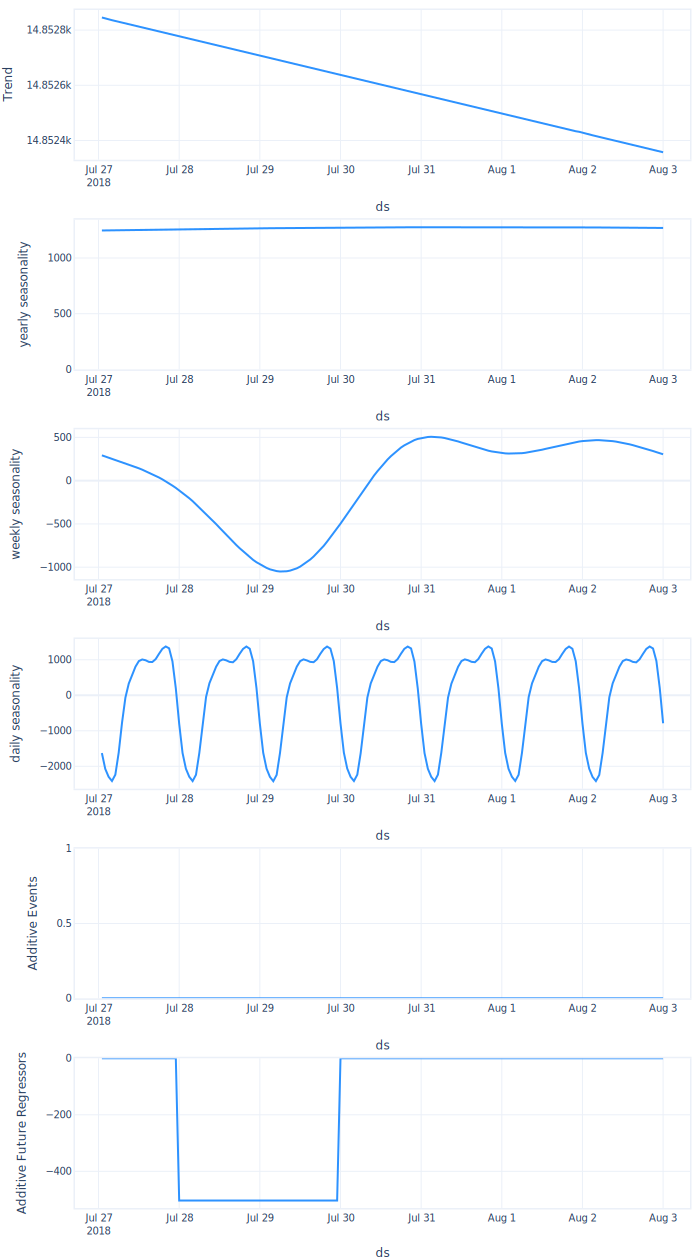

In [36]:
# interactive plotly
# m.plot_components(forecast_exog)

# static plotly
m.plot_components(forecast_exog, plotting_backend='plotly-static')

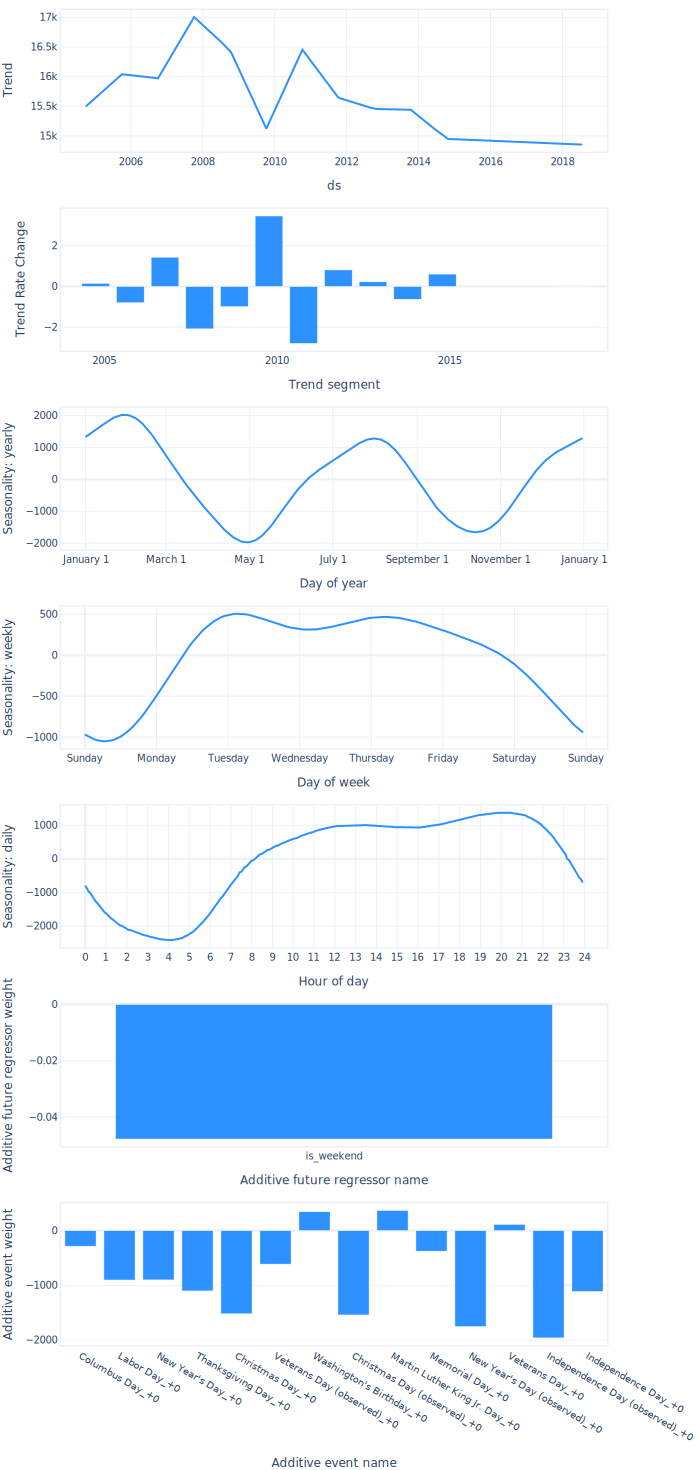

In [37]:
# interactive plotly
# m.plot_parameters()

# static plotly
m.plot_parameters(plotting_backend='plotly-static')

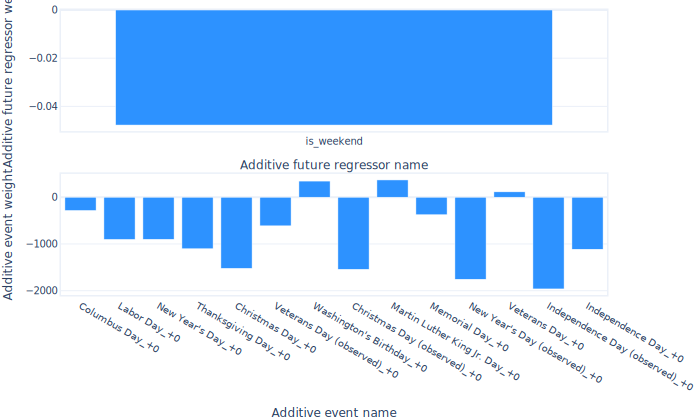

In [38]:
m.plot_parameters(components=['events', 'future_regressors'], 
                  plotting_backend='plotly-static')

In [39]:
test_results = m.test(df=test_np)
print(test_results)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.405% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - h


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.030331600457429886
         MAE_val            1241.5560302734375
        RMSE_val            1422.0611572265625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      MAE_val     RMSE_val  Loss_test  RegLoss_test
0  1241.55603  1422.061157   0.030332           0.0
